Epoch [1/30], Loss: 0.7053, Train Accuracy: 0.7073, Validation Accuracy: 0.8602
Epoch [2/30], Loss: 0.3681, Train Accuracy: 0.8605, Validation Accuracy: 0.9189
Epoch [3/30], Loss: 0.2547, Train Accuracy: 0.9055, Validation Accuracy: 0.9595
Epoch [4/30], Loss: 0.1938, Train Accuracy: 0.9303, Validation Accuracy: 0.9807
Epoch [5/30], Loss: 0.1504, Train Accuracy: 0.9474, Validation Accuracy: 0.9919
Epoch [6/30], Loss: 0.1226, Train Accuracy: 0.9625, Validation Accuracy: 0.9929
Epoch [7/30], Loss: 0.1070, Train Accuracy: 0.9665, Validation Accuracy: 0.9970
Epoch [8/30], Loss: 0.1025, Train Accuracy: 0.9668, Validation Accuracy: 1.0000
Epoch [9/30], Loss: 0.0877, Train Accuracy: 0.9714, Validation Accuracy: 1.0000
Epoch [10/30], Loss: 0.0757, Train Accuracy: 0.9771, Validation Accuracy: 0.9990
Epoch [11/30], Loss: 0.0798, Train Accuracy: 0.9754, Validation Accuracy: 0.9970
Epoch [12/30], Loss: 0.0675, Train Accuracy: 0.9783, Validation Accuracy: 1.0000
Epoch [13/30], Loss: 0.0608, Train Ac

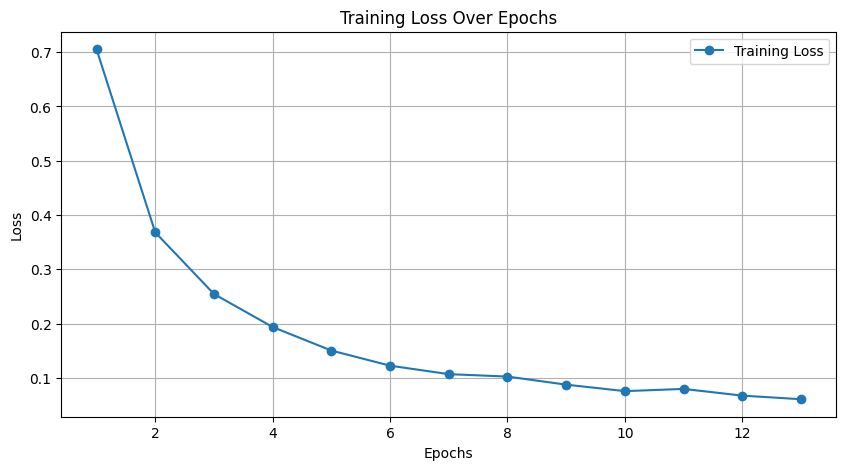

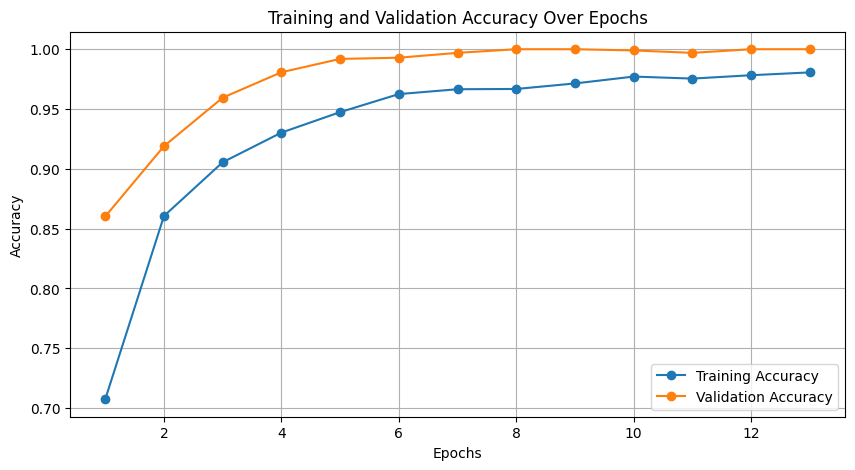

Test Accuracy: 99.92%


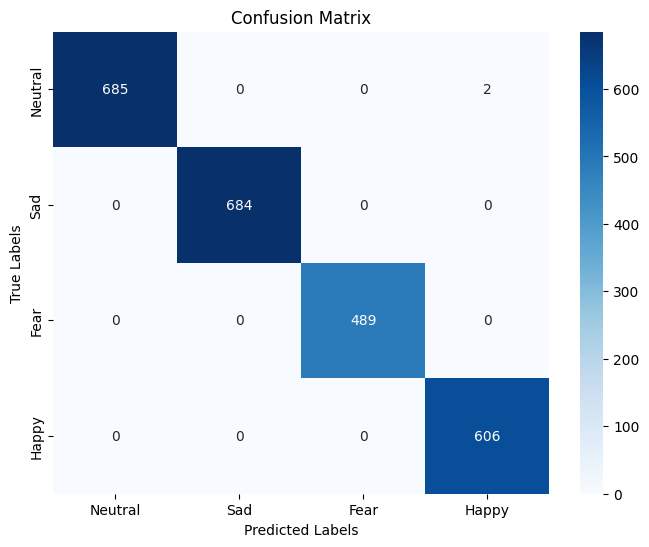


Classification Report:
              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00       687
         Sad       1.00      1.00      1.00       684
        Fear       1.00      1.00      1.00       489
       Happy       1.00      1.00      1.00       606

    accuracy                           1.00      2466
   macro avg       1.00      1.00      1.00      2466
weighted avg       1.00      1.00      1.00      2466



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_3_combined_with_labels.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):
    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader, y_test

# Define the model
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(31, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 4)  # Output for 4 classes
        )

    def forward(self, x):
        return self.fc(x)

# Training Function with Loss and Accuracy Plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    train_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy_train)
        val_accuracies.append(epoch_accuracy_val)

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

    # Plot Loss and Accuracy
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluation Function
def evaluate_model(model, test_loader, y_test):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Neutral", "Sad", "Fear", "Happy"],
                yticklabels=["Neutral", "Sad", "Fear", "Happy"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Neutral", "Sad", "Fear", "Happy"]))

# Main Workflow
train_loader, val_loader, test_loader, y_test = preprocess_combined_data(combined_csv)
model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader, y_test)


Epoch [1/30], Loss: 0.9221, Train Accuracy: 0.6037, Validation Accuracy: 0.7029
Epoch [2/30], Loss: 0.7148, Train Accuracy: 0.7071, Validation Accuracy: 0.7615
Epoch [3/30], Loss: 0.6437, Train Accuracy: 0.7361, Validation Accuracy: 0.8124
Epoch [4/30], Loss: 0.5974, Train Accuracy: 0.7569, Validation Accuracy: 0.8220
Epoch [5/30], Loss: 0.5632, Train Accuracy: 0.7741, Validation Accuracy: 0.8383
Epoch [6/30], Loss: 0.5337, Train Accuracy: 0.7854, Validation Accuracy: 0.8619
Epoch [7/30], Loss: 0.5128, Train Accuracy: 0.7947, Validation Accuracy: 0.8746
Epoch [8/30], Loss: 0.4919, Train Accuracy: 0.8001, Validation Accuracy: 0.8869
Epoch [9/30], Loss: 0.4831, Train Accuracy: 0.8075, Validation Accuracy: 0.8859
Epoch [10/30], Loss: 0.4744, Train Accuracy: 0.8082, Validation Accuracy: 0.8886
Epoch [11/30], Loss: 0.4603, Train Accuracy: 0.8141, Validation Accuracy: 0.9102
Epoch [12/30], Loss: 0.4519, Train Accuracy: 0.8203, Validation Accuracy: 0.9135
Epoch [13/30], Loss: 0.4513, Train Ac

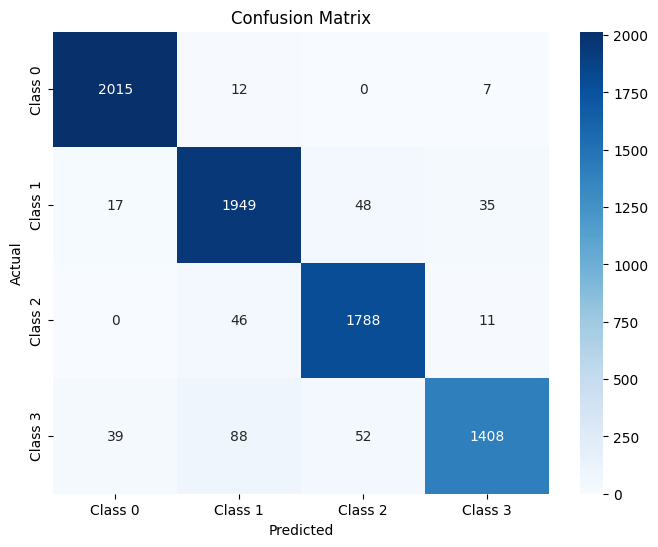


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2034
           1       0.93      0.95      0.94      2049
           2       0.95      0.97      0.96      1845
           3       0.96      0.89      0.92      1587

    accuracy                           0.95      7515
   macro avg       0.95      0.95      0.95      7515
weighted avg       0.95      0.95      0.95      7515



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_1_2_3_combined.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):

    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Subnetwork Class
class SubNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SubNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.fc(x)

# Attention Mechanism Class
class FeatureGroupAttention(nn.Module):
    def __init__(self, input_dims):
        super(FeatureGroupAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(len(input_dims)))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, feature_groups):
        weights = self.softmax(self.attention_weights)
        weighted_features = [w * fg for w, fg in zip(weights, feature_groups)]
        return torch.cat(weighted_features, dim=1)

# Main Model Class
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        # Subnetworks for Pupil and Event Statistics
        self.pupil_net = SubNetwork(12, 16)
        self.event_stats_net = SubNetwork(9, 16)

        # Combined Subnetwork for Dispersion, Fixation, and Saccade
        self.combined_net = SubNetwork(10, 20)

        # Attention mechanism for three groups
        self.attention = FeatureGroupAttention([16, 16, 20])

        # Fusion and Classification layers
        self.fusion = nn.Sequential(
            nn.Linear(52, 32),  # Adjust input size based on concatenated features
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(32, 4)  # Assuming 4 classes

    def forward(self, x):
        # Process each group
        pupil = self.pupil_net(x[:, :12])
        combined = self.combined_net(x[:, 12:22])  # Combined dispersion, fixation, and saccade
        event_stats = self.event_stats_net(x[:, 22:])

        # Apply attention to feature groups
        weighted_features = self.attention([pupil, combined, event_stats])

        # Fuse and classify
        fused = self.fusion(weighted_features)
        return self.classifier(fused)


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

# Evaluation Function



def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


# Main Workflow
train_loader, val_loader, test_loader = preprocess_combined_data(combined_csv)

model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader)


Epoch [1/30], Loss: 0.9991, Train Accuracy: 0.5515, Validation Accuracy: 0.7329
Epoch [2/30], Loss: 0.7009, Train Accuracy: 0.7098, Validation Accuracy: 0.7926
Epoch [3/30], Loss: 0.5912, Train Accuracy: 0.7507, Validation Accuracy: 0.8327
Epoch [4/30], Loss: 0.5078, Train Accuracy: 0.7914, Validation Accuracy: 0.8552
Epoch [5/30], Loss: 0.4554, Train Accuracy: 0.8195, Validation Accuracy: 0.8953
Epoch [6/30], Loss: 0.4188, Train Accuracy: 0.8324, Validation Accuracy: 0.8992
Epoch [7/30], Loss: 0.4003, Train Accuracy: 0.8461, Validation Accuracy: 0.9100
Epoch [8/30], Loss: 0.3659, Train Accuracy: 0.8571, Validation Accuracy: 0.9560
Epoch [9/30], Loss: 0.3508, Train Accuracy: 0.8637, Validation Accuracy: 0.9530
Epoch [10/30], Loss: 0.3144, Train Accuracy: 0.8819, Validation Accuracy: 0.9765
Epoch [11/30], Loss: 0.3091, Train Accuracy: 0.8836, Validation Accuracy: 0.9677
Epoch [12/30], Loss: 0.2980, Train Accuracy: 0.8905, Validation Accuracy: 0.9706
Epoch [13/30], Loss: 0.2725, Train Ac

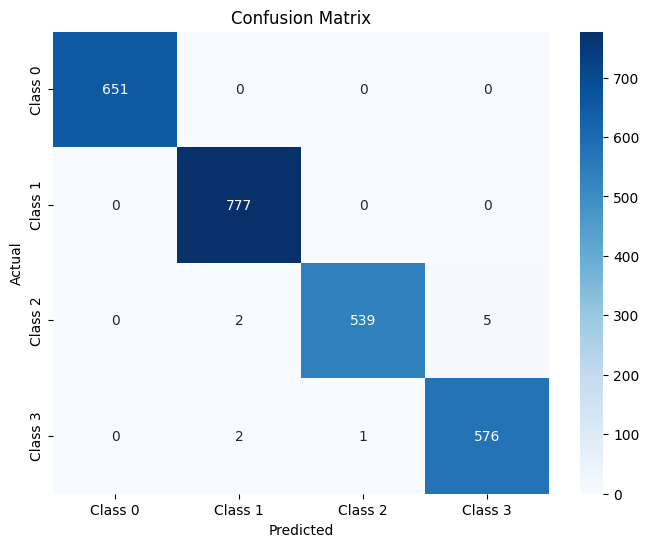


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       651
           1       0.99      1.00      1.00       777
           2       1.00      0.99      0.99       546
           3       0.99      0.99      0.99       579

    accuracy                           1.00      2553
   macro avg       1.00      1.00      1.00      2553
weighted avg       1.00      1.00      1.00      2553



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_1_combined_with_corrected_labels.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):

    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Subnetwork Class
class SubNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SubNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.fc(x)

# Attention Mechanism Class
class FeatureGroupAttention(nn.Module):
    def __init__(self, input_dims):
        super(FeatureGroupAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(len(input_dims)))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, feature_groups):
        weights = self.softmax(self.attention_weights)
        weighted_features = [w * fg for w, fg in zip(weights, feature_groups)]
        return torch.cat(weighted_features, dim=1)

# Main Model Class
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        # Subnetworks for Pupil and Event Statistics
        self.pupil_net = SubNetwork(12, 16)
        self.event_stats_net = SubNetwork(9, 16)

        # Combined Subnetwork for Dispersion, Fixation, and Saccade
        self.combined_net = SubNetwork(10, 20)

        # Attention mechanism for three groups
        self.attention = FeatureGroupAttention([16, 16, 20])

        # Fusion and Classification layers
        self.fusion = nn.Sequential(
            nn.Linear(52, 32),  # Adjust input size based on concatenated features
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(32, 4)  # Assuming 4 classes

    def forward(self, x):
        # Process each group
        pupil = self.pupil_net(x[:, :12])
        combined = self.combined_net(x[:, 12:22])  # Combined dispersion, fixation, and saccade
        event_stats = self.event_stats_net(x[:, 22:])

        # Apply attention to feature groups
        weighted_features = self.attention([pupil, combined, event_stats])

        # Fuse and classify
        fused = self.fusion(weighted_features)
        return self.classifier(fused)


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

# Evaluation Function



def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


# Main Workflow
train_loader, val_loader, test_loader = preprocess_combined_data(combined_csv)

model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader)


Epoch [1/30], Loss: 0.9306, Train Accuracy: 0.5863, Validation Accuracy: 0.7397
Epoch [2/30], Loss: 0.6388, Train Accuracy: 0.7408, Validation Accuracy: 0.8258
Epoch [3/30], Loss: 0.5525, Train Accuracy: 0.7802, Validation Accuracy: 0.8609
Epoch [4/30], Loss: 0.4850, Train Accuracy: 0.8139, Validation Accuracy: 0.8769
Epoch [5/30], Loss: 0.4356, Train Accuracy: 0.8323, Validation Accuracy: 0.9019
Epoch [6/30], Loss: 0.4010, Train Accuracy: 0.8461, Validation Accuracy: 0.9419
Epoch [7/30], Loss: 0.3642, Train Accuracy: 0.8652, Validation Accuracy: 0.9399
Epoch [8/30], Loss: 0.3321, Train Accuracy: 0.8752, Validation Accuracy: 0.9520
Epoch [9/30], Loss: 0.3140, Train Accuracy: 0.8825, Validation Accuracy: 0.9530
Epoch [10/30], Loss: 0.3059, Train Accuracy: 0.8818, Validation Accuracy: 0.9600
Epoch [11/30], Loss: 0.2817, Train Accuracy: 0.8969, Validation Accuracy: 0.9740
Epoch [12/30], Loss: 0.2766, Train Accuracy: 0.8949, Validation Accuracy: 0.9780
Epoch [13/30], Loss: 0.2584, Train Ac

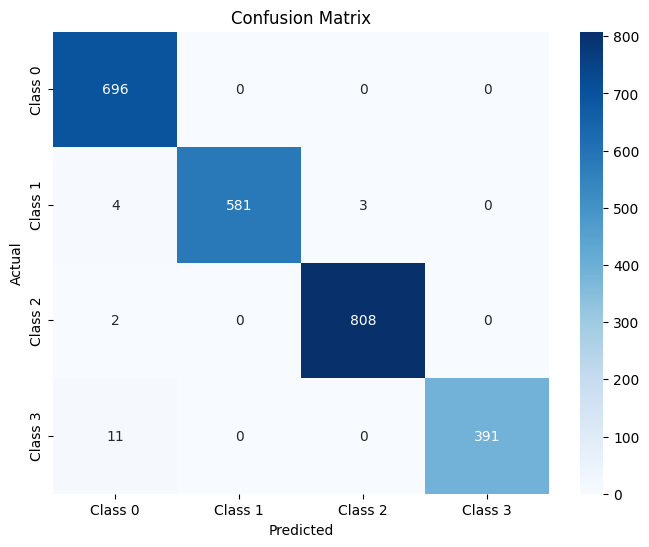


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       696
           1       1.00      0.99      0.99       588
           2       1.00      1.00      1.00       810
           3       1.00      0.97      0.99       402

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_2_combined_with_labels.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):

    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Subnetwork Class
class SubNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SubNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.fc(x)

# Attention Mechanism Class
class FeatureGroupAttention(nn.Module):
    def __init__(self, input_dims):
        super(FeatureGroupAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(len(input_dims)))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, feature_groups):
        weights = self.softmax(self.attention_weights)
        weighted_features = [w * fg for w, fg in zip(weights, feature_groups)]
        return torch.cat(weighted_features, dim=1)

# Main Model Class
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        # Subnetworks for Pupil and Event Statistics
        self.pupil_net = SubNetwork(12, 16)
        self.event_stats_net = SubNetwork(9, 16)

        # Combined Subnetwork for Dispersion, Fixation, and Saccade
        self.combined_net = SubNetwork(10, 20)

        # Attention mechanism for three groups
        self.attention = FeatureGroupAttention([16, 16, 20])

        # Fusion and Classification layers
        self.fusion = nn.Sequential(
            nn.Linear(52, 32),  # Adjust input size based on concatenated features
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(32, 4)  # Assuming 4 classes

    def forward(self, x):
        # Process each group
        pupil = self.pupil_net(x[:, :12])
        combined = self.combined_net(x[:, 12:22])  # Combined dispersion, fixation, and saccade
        event_stats = self.event_stats_net(x[:, 22:])

        # Apply attention to feature groups
        weighted_features = self.attention([pupil, combined, event_stats])

        # Fuse and classify
        fused = self.fusion(weighted_features)
        return self.classifier(fused)


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

# Evaluation Function



def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


# Main Workflow
train_loader, val_loader, test_loader = preprocess_combined_data(combined_csv)

model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader)


Epoch [1/30], Loss: 0.9052, Train Accuracy: 0.6137, Validation Accuracy: 0.7312
Epoch [2/30], Loss: 0.6973, Train Accuracy: 0.7136, Validation Accuracy: 0.7901
Epoch [3/30], Loss: 0.6236, Train Accuracy: 0.7487, Validation Accuracy: 0.8208
Epoch [4/30], Loss: 0.5773, Train Accuracy: 0.7671, Validation Accuracy: 0.8485
Epoch [5/30], Loss: 0.5401, Train Accuracy: 0.7807, Validation Accuracy: 0.8658
Epoch [6/30], Loss: 0.5121, Train Accuracy: 0.7927, Validation Accuracy: 0.8847
Epoch [7/30], Loss: 0.4925, Train Accuracy: 0.8086, Validation Accuracy: 0.8936
Epoch [8/30], Loss: 0.4668, Train Accuracy: 0.8140, Validation Accuracy: 0.9005
Epoch [9/30], Loss: 0.4592, Train Accuracy: 0.8213, Validation Accuracy: 0.9139
Epoch [10/30], Loss: 0.4458, Train Accuracy: 0.8252, Validation Accuracy: 0.9178
Epoch [11/30], Loss: 0.4366, Train Accuracy: 0.8272, Validation Accuracy: 0.9277
Epoch [12/30], Loss: 0.4215, Train Accuracy: 0.8340, Validation Accuracy: 0.9327
Epoch [13/30], Loss: 0.4087, Train Ac

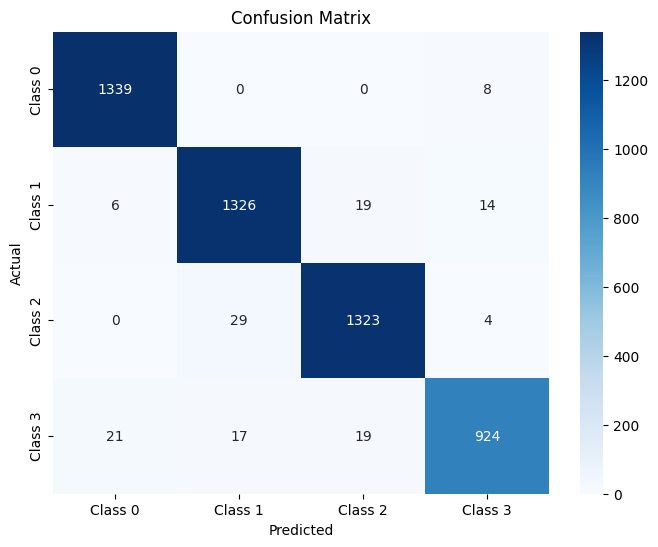


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1347
           1       0.97      0.97      0.97      1365
           2       0.97      0.98      0.97      1356
           3       0.97      0.94      0.96       981

    accuracy                           0.97      5049
   macro avg       0.97      0.97      0.97      5049
weighted avg       0.97      0.97      0.97      5049



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_1_2_combined.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):

    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Subnetwork Class
class SubNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SubNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.fc(x)

# Attention Mechanism Class
class FeatureGroupAttention(nn.Module):
    def __init__(self, input_dims):
        super(FeatureGroupAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(len(input_dims)))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, feature_groups):
        weights = self.softmax(self.attention_weights)
        weighted_features = [w * fg for w, fg in zip(weights, feature_groups)]
        return torch.cat(weighted_features, dim=1)

# Main Model Class
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        # Subnetworks for Pupil and Event Statistics
        self.pupil_net = SubNetwork(12, 16)
        self.event_stats_net = SubNetwork(9, 16)

        # Combined Subnetwork for Dispersion, Fixation, and Saccade
        self.combined_net = SubNetwork(10, 20)

        # Attention mechanism for three groups
        self.attention = FeatureGroupAttention([16, 16, 20])

        # Fusion and Classification layers
        self.fusion = nn.Sequential(
            nn.Linear(52, 32),  # Adjust input size based on concatenated features
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(32, 4)  # Assuming 4 classes

    def forward(self, x):
        # Process each group
        pupil = self.pupil_net(x[:, :12])
        combined = self.combined_net(x[:, 12:22])  # Combined dispersion, fixation, and saccade
        event_stats = self.event_stats_net(x[:, 22:])

        # Apply attention to feature groups
        weighted_features = self.attention([pupil, combined, event_stats])

        # Fuse and classify
        fused = self.fusion(weighted_features)
        return self.classifier(fused)


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

# Evaluation Function



def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


# Main Workflow
train_loader, val_loader, test_loader = preprocess_combined_data(combined_csv)

model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader)


Epoch [1/30], Loss: 0.9399, Train Accuracy: 0.5917, Validation Accuracy: 0.7729
Epoch [2/30], Loss: 0.6494, Train Accuracy: 0.7387, Validation Accuracy: 0.8232
Epoch [3/30], Loss: 0.5599, Train Accuracy: 0.7731, Validation Accuracy: 0.8640
Epoch [4/30], Loss: 0.5141, Train Accuracy: 0.7920, Validation Accuracy: 0.8710
Epoch [5/30], Loss: 0.4734, Train Accuracy: 0.8068, Validation Accuracy: 0.8909
Epoch [6/30], Loss: 0.4453, Train Accuracy: 0.8218, Validation Accuracy: 0.9218
Epoch [7/30], Loss: 0.4150, Train Accuracy: 0.8312, Validation Accuracy: 0.9178
Epoch [8/30], Loss: 0.4087, Train Accuracy: 0.8363, Validation Accuracy: 0.9228
Epoch [9/30], Loss: 0.3965, Train Accuracy: 0.8425, Validation Accuracy: 0.9248
Epoch [10/30], Loss: 0.3811, Train Accuracy: 0.8486, Validation Accuracy: 0.9537
Epoch [11/30], Loss: 0.3668, Train Accuracy: 0.8539, Validation Accuracy: 0.9597
Epoch [12/30], Loss: 0.3557, Train Accuracy: 0.8629, Validation Accuracy: 0.9452
Epoch [13/30], Loss: 0.3504, Train Ac

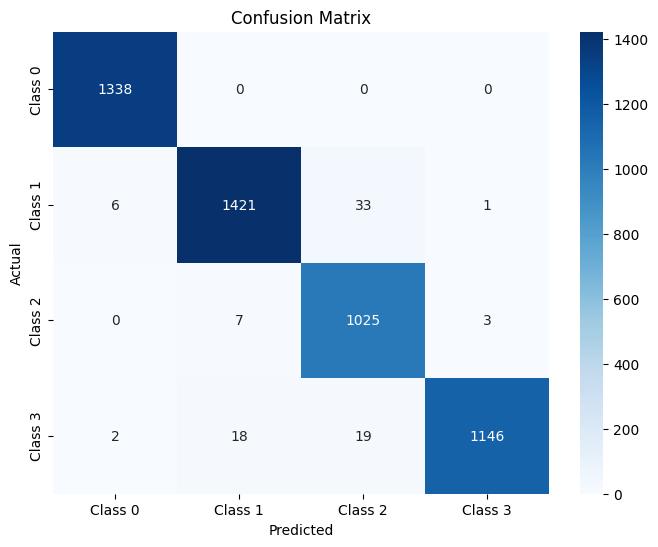


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1338
           1       0.98      0.97      0.98      1461
           2       0.95      0.99      0.97      1035
           3       1.00      0.97      0.98      1185

    accuracy                           0.98      5019
   macro avg       0.98      0.98      0.98      5019
weighted avg       0.98      0.98      0.98      5019



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_1_3_combined.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):

    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Subnetwork Class
class SubNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SubNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.fc(x)

# Attention Mechanism Class
class FeatureGroupAttention(nn.Module):
    def __init__(self, input_dims):
        super(FeatureGroupAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(len(input_dims)))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, feature_groups):
        weights = self.softmax(self.attention_weights)
        weighted_features = [w * fg for w, fg in zip(weights, feature_groups)]
        return torch.cat(weighted_features, dim=1)

# Main Model Class
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        # Subnetworks for Pupil and Event Statistics
        self.pupil_net = SubNetwork(12, 16)
        self.event_stats_net = SubNetwork(9, 16)

        # Combined Subnetwork for Dispersion, Fixation, and Saccade
        self.combined_net = SubNetwork(10, 20)

        # Attention mechanism for three groups
        self.attention = FeatureGroupAttention([16, 16, 20])

        # Fusion and Classification layers
        self.fusion = nn.Sequential(
            nn.Linear(52, 32),  # Adjust input size based on concatenated features
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(32, 4)  # Assuming 4 classes

    def forward(self, x):
        # Process each group
        pupil = self.pupil_net(x[:, :12])
        combined = self.combined_net(x[:, 12:22])  # Combined dispersion, fixation, and saccade
        event_stats = self.event_stats_net(x[:, 22:])

        # Apply attention to feature groups
        weighted_features = self.attention([pupil, combined, event_stats])

        # Fuse and classify
        fused = self.fusion(weighted_features)
        return self.classifier(fused)


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

# Evaluation Function



def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


# Main Workflow
train_loader, val_loader, test_loader = preprocess_combined_data(combined_csv)

model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader)


Epoch [1/30], Loss: 0.8955, Train Accuracy: 0.6176, Validation Accuracy: 0.7652
Epoch [2/30], Loss: 0.6512, Train Accuracy: 0.7355, Validation Accuracy: 0.8146
Epoch [3/30], Loss: 0.5499, Train Accuracy: 0.7825, Validation Accuracy: 0.8469
Epoch [4/30], Loss: 0.4969, Train Accuracy: 0.8009, Validation Accuracy: 0.8695
Epoch [5/30], Loss: 0.4541, Train Accuracy: 0.8221, Validation Accuracy: 0.8882
Epoch [6/30], Loss: 0.4271, Train Accuracy: 0.8323, Validation Accuracy: 0.9078
Epoch [7/30], Loss: 0.4010, Train Accuracy: 0.8421, Validation Accuracy: 0.9239
Epoch [8/30], Loss: 0.3783, Train Accuracy: 0.8531, Validation Accuracy: 0.9375
Epoch [9/30], Loss: 0.3578, Train Accuracy: 0.8596, Validation Accuracy: 0.9421
Epoch [10/30], Loss: 0.3473, Train Accuracy: 0.8644, Validation Accuracy: 0.9476
Epoch [11/30], Loss: 0.3373, Train Accuracy: 0.8708, Validation Accuracy: 0.9557
Epoch [12/30], Loss: 0.3310, Train Accuracy: 0.8748, Validation Accuracy: 0.9577
Epoch [13/30], Loss: 0.3162, Train Ac

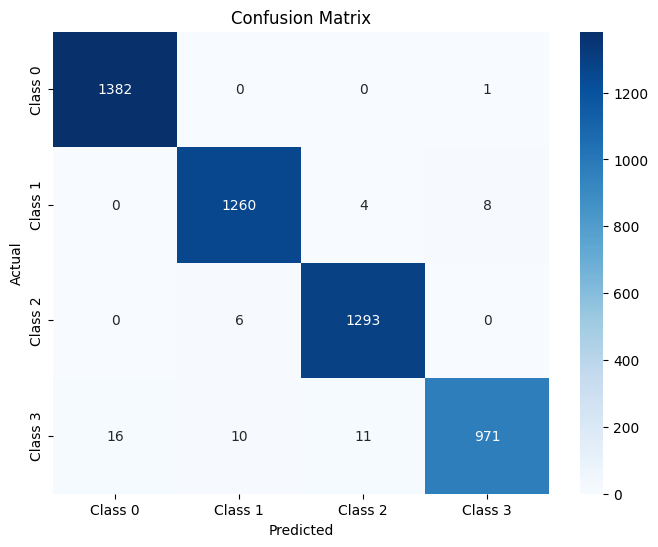


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1383
           1       0.99      0.99      0.99      1272
           2       0.99      1.00      0.99      1299
           3       0.99      0.96      0.98      1008

    accuracy                           0.99      4962
   macro avg       0.99      0.99      0.99      4962
weighted avg       0.99      0.99      0.99      4962



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
combined_csv = "/content/session_2_3_combined.csv"

# Preprocessing Function
def preprocess_combined_data(combined_csv, test_size=0.2, val_size=0.1):

    # Load the dataset
    data = pd.read_csv(combined_csv)

    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)

    # Split features and labels
    X = data.iloc[:, :-1].values  # Features (all columns except the last)
    y = data.iloc[:, -1].values   # Labels (last column)

    # Split into train+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Further split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    # Create DataLoaders
    train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Subnetwork Class
class SubNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SubNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.fc(x)

# Attention Mechanism Class
class FeatureGroupAttention(nn.Module):
    def __init__(self, input_dims):
        super(FeatureGroupAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(len(input_dims)))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, feature_groups):
        weights = self.softmax(self.attention_weights)
        weighted_features = [w * fg for w, fg in zip(weights, feature_groups)]
        return torch.cat(weighted_features, dim=1)

# Main Model Class
class DGCCA_AM_CombinedSubnetwork(nn.Module):
    def __init__(self):
        super(DGCCA_AM_CombinedSubnetwork, self).__init__()
        # Subnetworks for Pupil and Event Statistics
        self.pupil_net = SubNetwork(12, 16)
        self.event_stats_net = SubNetwork(9, 16)

        # Combined Subnetwork for Dispersion, Fixation, and Saccade
        self.combined_net = SubNetwork(10, 20)

        # Attention mechanism for three groups
        self.attention = FeatureGroupAttention([16, 16, 20])

        # Fusion and Classification layers
        self.fusion = nn.Sequential(
            nn.Linear(52, 32),  # Adjust input size based on concatenated features
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(32, 4)  # Assuming 4 classes

    def forward(self, x):
        # Process each group
        pupil = self.pupil_net(x[:, :12])
        combined = self.combined_net(x[:, 12:22])  # Combined dispersion, fixation, and saccade
        event_stats = self.event_stats_net(x[:, 22:])

        # Apply attention to feature groups
        weighted_features = self.attention([pupil, combined, event_stats])

        # Fuse and classify
        fused = self.fusion(weighted_features)
        return self.classifier(fused)


# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_preds_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy_train = correct_preds_train / total_preds_train

        # Validation
        model.eval()
        correct_preds_val = 0
        total_preds_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_preds_val += labels.size(0)

        epoch_accuracy_val = correct_preds_val / total_preds_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")

        if epoch_accuracy_val > best_val_accuracy:
            best_val_accuracy = epoch_accuracy_val
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy.")
            break

# Evaluation Function



def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    # Calculate and display accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix with seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


# Main Workflow
train_loader, val_loader, test_loader = preprocess_combined_data(combined_csv)

model = DGCCA_AM_CombinedSubnetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)
evaluate_model(model, test_loader)


In [ ]:

from collections import Counter

def calculate_label_distribution(loader, split_name="Dataset"):

    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())
    total = len(all_labels)
    label_counts = Counter(all_labels)
    print(f"Label Distribution in {split_name}:")
    for label, count in sorted(label_counts.items()):
        percentage = (count / total) * 100
        print(f"  Label {label}: {count} samples ({percentage:.2f}%)")

# Calculate distributions
calculate_label_distribution(train_loader, split_name="Train")
calculate_label_distribution(val_loader, split_name="Validation")
calculate_label_distribution(test_loader, split_name="Test")


Label Distribution in Train:
  Label 0: 2473 samples (27.86%)
  Label 1: 2462 samples (27.73%)
  Label 2: 1760 samples (19.83%)
  Label 3: 2182 samples (24.58%)
Label Distribution in Validation:
  Label 0: 275 samples (27.86%)
  Label 1: 274 samples (27.76%)
  Label 2: 196 samples (19.86%)
  Label 3: 242 samples (24.52%)
Label Distribution in Test:
  Label 0: 687 samples (27.86%)
  Label 1: 684 samples (27.74%)
  Label 2: 489 samples (19.83%)
  Label 3: 606 samples (24.57%)


In [ ]:

def calculate_split_distribution(train_loader, val_loader, test_loader):

    train_samples = sum(len(labels) for _, labels in train_loader)
    val_samples = sum(len(labels) for _, labels in val_loader)
    test_samples = sum(len(labels) for _, labels in test_loader)
    total_samples = train_samples + val_samples + test_samples

    print("Split Distribution:")
    print(f"  Train: {train_samples} samples ({(train_samples / total_samples) * 100:.2f}%)")
    print(f"  Validation: {val_samples} samples ({(val_samples / total_samples) * 100:.2f}%)")
    print(f"  Test: {test_samples} samples ({(test_samples / total_samples) * 100:.2f}%)")

calculate_split_distribution(train_loader, val_loader, test_loader)


Split Distribution:
  Train: 8877 samples (72.00%)
  Validation: 987 samples (8.00%)
  Test: 2466 samples (20.00%)



# Objective:

To classify emotions using eye movement data processed through a DGCCA-AM-inspired neural network.


  ## The dataset contains 31 features related to eye movement grouped into five categories:
        Pupil (12 features)
        Dispersion (4 features)
        Fixation (2 features)
        Saccade (4 features)
        Event Statistics (9 features)
  
  - The model treats each feature group as a separate modality
- Each group of features is processed by a dedicated neural network, or subnetwork.
 - After processing, the outputs from these subnetworks are passed through an attention mechanism.
- The attention mechanism assigns a weight to each feature group, dynamically deciding which groups are more important for predicting emotions.

# Key Methods:

   Feature Grouping and Attention:

        Features are split into groups based on their physiological relevance.
        Each group is passed through a dedicated subnetwork.
        An attention mechanism dynamically assigns importance to each group, weighting their contributions.

  # Fusion and Classification:
        Outputs from subnetworks are concatenated, compressed into a shared latent space (dimensionality = 32), and passed to a classifier.

  # Training Procedure:
        The model is trained on 70% of the data, with 10% reserved for validation and 20% for testing.
        Early stopping is used to avoid overfitting.